In [ ]:
import xmltodict
import requests
import json
import os

from tqdm import tqdm
from bs4 import BeautifulSoup
from mistralai import Mistral
from shapely import box
from more_itertools import flatten
from itertools import repeat

import geopandas as gpd
import networkx as nx

api_key='IVtm2djSa1lDHLs3pIY7z6i5GSvUl5X7'
#api_key=os.getenv("MISTRAL_API_KEY", "")
llm = Mistral(api_key=api_key)


soup = BeautifulSoup(wms_response.content, 'xml')

In [ ]:
#load previously downloaded district-level boundary data from HDX

districts=gpd.read_file('geoBoundariesCGAZ_ADM2.geojson')
districts.plot()

In [ ]:
#translation and keyword labeling prompt
keyword_prompt='Given the following text, extract key phrases translated to English from the original language. Return the original text, the language of the text (in English), and the text translated to English. Also tag each key phrase with "data", "geospatial", "thematic","source","methodology" as is appropriate to the key phrase. Finally provide a single, 1-to-3 word english-language description of the dataset. Be as concise as possible with this description. The resultant data should be formatted as a JSON list of 5-tuples(original text, language, translated text, tag, description) for each key phrase:'

In [23]:
wms_urls=['https://maps.dwd.de/geoserver/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities']


In [107]:
def layers_from_wms(url):
    wms_response=requests.get(wms_url)
    wms_metadata=xmltodict.parse(wms_response.content)

    server_keywords=[i.get_text() for i in soup.KeywordList.find_all('Keyword')]

    datasets=[]

    for layer in tqdm(list(soup.find_all('Layer'))):
        title=layer.Title.get_text()
        abstract=layer.Abstract.get_text()
        #ne sw
        try:
            bounds=layer.EX_GeographicBoundingBox
                #box(xmin, ymin, xmax, ymax)

            x=sorted([
                bounds.westBoundLongitude.get_text(),
                bounds.eastBoundLongitude.get_text()
            ])

            y=sorted([
                bounds.northBoundLatitude.get_text(),
                bounds.southBoundLatitude.get_text()
            ])

            bb=(x[0],y[0],x[1],y[1])

            #print(x,y)

                
            bb=[float(i) for i in bb]

        except:
            bb=None

        #print(title,abstract,bb)

        kws=[i.get_text() for i in layer.KeywordList.find_all('Keyword')]

        dataset={'extracted':{
                'title':title,
                'description':abstract,
                'source':url,
                'bounds':bb,
                'keywords':kws
            }
        }
        
        p=' '.join([keyword_prompt,title,'\n',abstract])

        kw_txt=''
        if len(kws)>0:
            kw_txt=kw_txt+'; '.join(kws)

        if len(server_keywords)>0:
            kw_txt=kw_txt+'; '.join(server_keywords)

        if len(kw_txt)>0:
            p=p+ '\nKeywords: '+kw_txt

        #print(p)

        #try:
        res = llm.chat.complete(
        model="mistral-small-latest", 
        messages=[
            {
                "content": p,
                "role": "user",
            },
        ],
        response_format={
                "type": "json_object",
            }
        )

        # Handle response
        #except:
        #    print('Mistal Error')

        try:
            dataset['modeled']=json.loads(res.choices[0].message.content)
            datasets.append(dataset)
        except:
            print('Fail on keyword extract')
            datasets.append(dataset)
            pass

    return datasets

datasets=[]

for wms_server in wms_urls:
    datasets.extend(layers_from_wms(wms_server))

100%|██████████| 183/183 [15:20<00:00,  5.03s/it]


In [108]:
edges=[]
for dataset in datasets:
    if 'modeled' in dataset:
        source_node=(dataset['extracted']['source'],dataset['extracted']['title'])
        for kw in dataset['modeled']:
            for field in kw:
                edges.append((source_node,field))
edges=set(edges)
nodes=set(list(flatten(edges)))

In [109]:
G=nx.DiGraph()

G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [114]:
len(G.edges)

5268

{'': array([-0.18797035,  0.01031365]), 'Horizontal resolution of 0.0625 degrees': array([ 0.36554711, -0.18820625]), ('https://maps.dwd.de/geoserver/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities', 'UV-Index (max)'): array([ 0.10665199, -0.15208941]), 'Höhenmittel der Windgeschwindigkeit': array([0.11892006, 0.30268692]), ('https://maps.dwd.de/geoserver/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities', 'UVZeit'): array([0.73641213, 0.48846968]), 'Luftfahrt': array([ 0.15254322, -0.31689461]), 'e.g. in the coastal area': array([-0.34519455,  0.13803869]), 'UV Index': array([ 0.10058287, -0.19793607]), 'NowCastMix method': array([ 0.46871798, -0.00623437]), 'WMO Regions': array([0.36122242, 0.14908479]), 'extreme snowfall': array([-0.28655706, -0.22356262]), 'horizontalen Bezugssystem WGS84': array([-0.58270279, -0.14467408]), 'Weather Sensitivity Indices': array([-0.34267758, -0.08723064]), 'Time intervals': array([ 0.1926616, -0.347117 ]), 'Elevation': array([-0.05688178,

KeyboardInterrupt: 

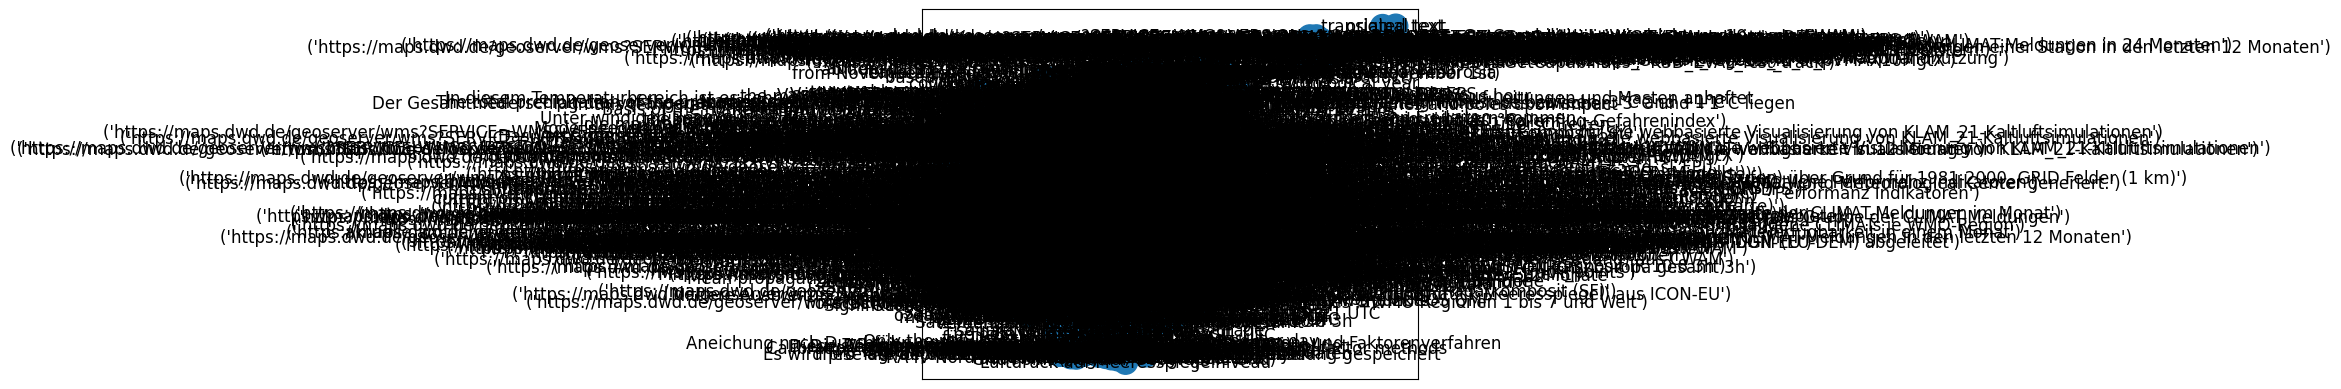

In [112]:
nx.display(G)

In [115]:
nx.draw(G,with_labels=False)

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 176, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


Error in callback <function flush_figures at 0x7f493af62fc0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [106]:
datasets

[{'extracted': {'title': 'DWD GeoServer WMS',
   'description': 'This is the Web Map Server of DWD.',
   'source': True,
   'bounds': [-180.0, -90.0, 180.0, 90.0],
   'keywords': [],
   'DWD GeoServer WMS': True,
   'German': True,
   'weather data': True,
   'Web Map Server': True,
   'methodology': True,
   'map server': True,
   'meteorology': True,
   'thematic': True,
   'climatology': True,
   'climate data': True,
   'geometry': <POLYGON ((180 -90, 180 90, -180 90, -180 -90, 180 -90))>,
   'kw_DWD GeoServer WMS': True,
   'kw_German': True,
   'kw_source': True,
   'kw_weather data': True,
   'kw_Web Map Server': True,
   'kw_methodology': True,
   'kw_map server': True,
   'kw_meteorology': True,
   'kw_thematic': True,
   'kw_climatology': True,
   'kw_climate data': True},
  'modeled': [['DWD GeoServer WMS',
    'German',
    'DWD GeoServer WMS',
    'source',
    'weather data'],
   ['Web Map Server', 'German', 'Web Map Server', 'methodology', 'map server'],
   ['meteorology

In [119]:
def datasets_to_bounding_box_polygons(datasets):
    for dataset in datasets:
        metadata=dataset['extracted']
        if 'modeled' in dataset:
            for kw in dataset['modeled']:
                for field in kw:
                    metadata['kw_'+field]=True
        if dataset['extracted']['bounds'] is not None:
            metadata['geometry']=box(*dataset['extracted']['bounds'])
        else:
            metadata['geometry']=None
        yield metadata

dataset_gpd=gpd.GeoDataFrame(datasets_to_bounding_box_polygons(datasets),crs='epsg:4326')

In [120]:
final_ds=districts.sjoin(dataset_gpd)

In [121]:
final_ds

,shapeName,shapeID,shapeGroup,shapeType,geometry,index_right,title,description,source,bounds,...,kw_Land Cover,kw_Baumartenkarte,kw_Tree Species Map,kw_Tree Species,"kw_Blickensdörfer et al., 2023",kw_Euro24 Stadien,kw_Euro24 Stadiums,kw_Euro24 stadiums,kw_Lage der an der Euro24 beteiligten Stadien,kw_Location of stadiums participating in Euro24
0,Deh Bala,17698898B67359070524975,AFG,ADM2,"POLYGON ((70.51142 33.9492, 70.51889 33.95499,...",0,DWD GeoServer WMS,This is the Web Map Server of DWD.,https://maps.dwd.de/geoserver/wms?SERVICE=WMS&...,"[-180.0, -90.0, 180.0, 90.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gulran,17698898B98443198567384,AFG,ADM2,"POLYGON ((62.0076 35.44597, 62.00551 35.44639,...",0,DWD GeoServer WMS,This is the Web Map Server of DWD.,https://maps.dwd.de/geoserver/wms?SERVICE=WMS&...,"[-180.0, -90.0, 180.0, 90.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gulran,17698898B98443198567384,AFG,ADM2,"POLYGON ((62.0076 35.44597, 62.00551 35.44639,...",1,Numerische Seegangsvorhersagen (WAM),Grundlage des numerischen Seegangsvorhersagesy...,https://maps.dwd.de/geoserver/wms?SERVICE=WMS&...,"[-23.53125, 29.46875, 62.53125, 70.53125]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Koshk,17698898B82675281335003,AFG,ADM2,"POLYGON ((61.99554 34.74465, 62.0176 34.73953,...",0,DWD GeoServer WMS,This is the Web Map Server of DWD.,https://maps.dwd.de/geoserver/wms?SERVICE=WMS&...,"[-180.0, -90.0, 180.0, 90.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Koshk,17698898B82675281335003,AFG,ADM2,"POLYGON ((61.99554 34.74465, 62.0176 34.73953,...",1,Numerische Seegangsvorhersagen (WAM),Grundlage des numerischen Seegangsvorhersagesy...,https://maps.dwd.de/geoserver/wms?SERVICE=WMS&...,"[-23.53125, 29.46875, 62.53125, 70.53125]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49346,Spratly Is,DIS018,128,DISP,"POLYGON ((114.33955 11.44331, 114.3383 11.4445...",0,DWD GeoServer WMS,This is the Web Map Server of DWD.,https://maps.dwd.de/geoserver/wms?SERVICE=WMS&...,"[-180.0, -90.0, 180.0, 90.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49347,West Bank,DIS019,129,DISP,"POLYGON ((35.55865 31.7635, 35.55857 31.76376,...",0,DWD GeoServer WMS,This is the Web Map Server of DWD.,https://maps.dwd.de/geoserver/wms?SERVICE=WMS&...,"[-180.0, -90.0, 180.0, 90.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49347,West Bank,DIS019,129,DISP,"POLYGON ((35.55865 31.7635, 35.55857 31.76376,...",3,Numerische Seegangsvorhersagen für europäische...,Grundlage des numerischen Seegangsvorhersagesy...,https://maps.dwd.de/geoserver/wms?SERVICE=WMS&...,"[-10.55, 29.975, 42.05, 66.025]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49347,West Bank,DIS019,129,DISP,"POLYGON ((35.55865 31.7635, 35.55857 31.76376,...",1,Numerische Seegangsvorhersagen (WAM),Grundlage des numerischen Seegangsvorhersagesy...,https://maps.dwd.de/geoserver/wms?SERVICE=WMS&...,"[-23.53125, 29.46875, 62.53125, 70.53125]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_ds.to_file("final_joined.geojson")